In [1]:
#% pip install scikit-survival lifelines matplotlib pandas numpy scikit-learn
import numpy as np
import pandas as pd
import os
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from config import DATA_ROOT
import matplotlib.pyplot as plt

In [2]:
csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #
df_raw = pd.read_csv(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()
df = df_raw.copy()

Raw shape: (272, 120)


In [3]:
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"
# create mapping from original column names to standardized names
col_mapping = {
    "Date of first recurrence per RANO (date of MRI)": "recurrence_date",
    "Date of death or last follow-up": "death_or_lastFU_date",
    "Death (1: yes / 0: no)": "event_death",
    "Age at diagnosis": "age_dx",
    "KPS before SRS or re-RT for Recurrence": "kps_pre",
    "Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)": "ce_volume_cm3",
    "SRS Dose (Gy)": "srs_dose_gy"
}

df = df.rename(columns=col_mapping)

time_points = [col_mapping[tp] for tp in time_points]
variables = [col_mapping[var] for var in variables]

# Compute survival time in days
df[time_points] = df[time_points].apply(pd.to_datetime, errors='coerce')
df["SurvivalTime(days)"] = (df[time_points[1]] - df[time_points[0]]).dt.days

/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_48640/1857275073.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_points] = df[time_points].apply(pd.to_datetime, errors='coerce')
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_48640/1857275073.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_points] = df[time_points].apply(pd.to_datetime, errors='coerce')


In [ ]:
# ----------------------------
# 1) Prepare your dataframe
# ----------------------------
# df must contain:
#   - time_col: survival time (e.g., days_post_recurrence)
#   - event_col: 1=event/death, 0=censored
#   - feature columns: predictors (age_dx, kps_pre, ce_volume_cm3, srs_dose_gy, ...)

time_col = "SurvivalTime(days)"
event_col = "event_death"
feature_cols = ["age_dx", "kps_pre", "ce_volume_cm3", "srs_dose_gy"]  # <-- change

df = df.copy()

# Ensure numeric features
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=[time_col, event_col] + feature_cols).reset_index(drop=True)

# scikit-survival expects a structured array y
y = Surv.from_arrays(event=df[event_col].astype(bool).values,
                     time=df[time_col].astype(float).values)

X = df[feature_cols].values

# ----------------------------
# 2) Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=df[event_col]
)

# ----------------------------
# 3) Fit an RPA survival tree
# ----------------------------
# These controls are important to avoid degenerate splits / "logrank=inf"
tree = SurvivalTree(
    max_depth=4,
    min_samples_split=50,
    min_samples_leaf=25,
    random_state=42
)
tree.fit(X_train, y_train)

# ----------------------------
# 4) Evaluate (C-index)
# ----------------------------
# predict returns risk scores (higher => higher risk)
risk_test = tree.predict(X_test)

cindex = concordance_index_censored(
    y_test["event"], y_test["time"], risk_test
)[0]
print(f"Test C-index: {cindex:.3f}")


Test C-index: 0.558


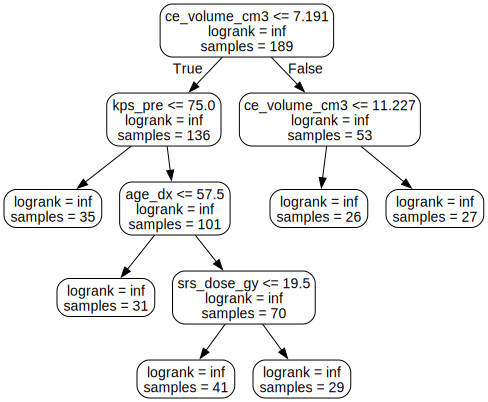

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    tree,
    out_file=None,
    feature_names=variables,
    filled=False, # Must be False to prevent the float NaN error
    rounded=True
)
# Render and view the tree
cleaned_lines = []
for line in dot_data.split('\n'):
    if "value =" in line:
        idx_value = line.index("value =") -2
        idx_last_bracket = line.rindex("]")-2
        cleaned_lines.append(line[:idx_value] + line[idx_last_bracket+1:])
    else:
        cleaned_lines.append(line)
dot_data_manual = '\n'.join(cleaned_lines)

# print(dot_data_manual)

graph = graphviz.Source(dot_data_manual)
graph.render("./survival_tree.pdf")  # Saves as survival_tree.pdf
graph